In [13]:
import librosa
import glob
import os
import dtw
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='dark')
%matplotlib inline

import msaf # develop branch
from msaf import jams2
import numpy as np
import scipy
import mir_eval

In [14]:
ds_path = "/Users/uriadmin/datasets/Segments/"

In [ ]:
%run 'Cross-repetition DTW.ipynb'

In [18]:
files = msaf.io.get_dataset_files(ds_path, ds_name="SALAMI")
print len(files)
ref_inter, ref_labels = jams2.converters.load_jams_range(
    files[0].ref_file, "sections", annotator=0, context="function")
print ref_inter, ref_labels
D, labels = make_cost_matrix(files[0].audio_file, ref_inter, ref_labels)

769
[[  0.00000000e+00   2.23000000e-01]
 [  2.23000000e-01   5.31620000e+01]
 [  5.31620000e+01   9.28200000e+01]
 [  9.28200000e+01   1.19208000e+02]
 [  1.19208000e+02   1.72036000e+02]
 [  1.72036000e+02   2.24811000e+02]
 [  2.24811000e+02   2.77775000e+02]
 [  2.77775000e+02   3.14269000e+02]] [u'silence', u'intro', u'verse', u'interlude', u'verse', u'bridge', u'verse', u'outro']


In [22]:
print D.shape

(8, 8)


In [19]:
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


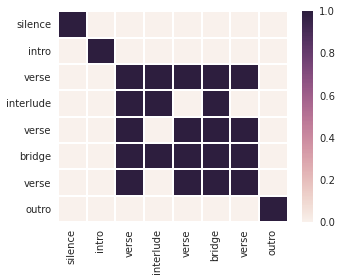

In [20]:
@interact(threshold=(0, D.max(), D.max()//50))
def _plot(threshold=0):
    plt.figure(figsize=(5,4))
    seaborn.heatmap((D<threshold), xticklabels=labels, yticklabels=labels)
    plt.tight_layout()